In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math

In [14]:
def findkernel(temp_grad, F_flux, time_interval, N_points, tau, m_sample, kernel_size, pre_kernel, tspan, n_epoch):

    # build single layer conv1d 
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    
    input_series = keras.layers.Input(temp_grad.shape[1:])
    output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
    model = keras.Model(input_series, output_series)
    weights = model.get_weights() # store the initial random weights
    new_weights = [np.random.randn(*w.shape) for w in weights]
    adam = keras.optimizers.Adam(epsilon = 1e-02) #adjust epsilon
    model.compile(
        optimizer=adam,
        loss= 'mean_squared_error',
        metrics=['mean_squared_error'])
    #model.summary()
    
    # split train and test sets
    X_train, X_rem, y_train, y_rem = train_test_split(temp_grad, F_flux, train_size=0.8)
    
    # train the model
    history = model.fit(X_train, y_train, epochs=n_epoch, validation_data=(X_rem, y_rem), callbacks=[callback])
    val_loss = history.history['val_loss']
    
    # get the kernel
    conv_kernel = model.weights[0][:,0,0]
    a = tf.constant(conv_kernel)
    conv_kernel = a.numpy()
    conv_kernel = conv_kernel[::-1]
    
    # reset random initial weights
    model.set_weights(new_weights)
    
    return (conv_kernel, val_loss)

In [15]:
time_interval = 6 # corresponding time interval duration in say days
N_points = 365 # red-noise vector length
m_sample = 10; # number of years
kernel_size = 40 # truncate the kernel to include some small number of points since we are assuming it decays with time
n_kernel = 50; # number of neural network
tspan = np.linspace(0, time_interval, N_points)
n_epoch = 8000; # epoch of each neural network

tau = 0.2 # define pre-defined kernel
pre_kernel = np.exp(-tspan/tau) 
pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
tspan_kernel = tspan[:kernel_size]
tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries

#import data
grad_sst = np.load('/Users/liyiran/Desktop/eddymemory/grad_SST.npy')
heat_flux = np.load('/Users/liyiran/Desktop/eddymemory/heat_flux.npy')
std_sst = np.std(grad_sst)
std_flux = np.std(heat_flux)
mean_sst = np.mean(grad_sst)
mean_flux = np.mean(heat_flux)

sst = grad_sst[0:365]
flux = heat_flux[0:365]

In [16]:
grad_sst.shape
heat_flux.shape

(3991,)

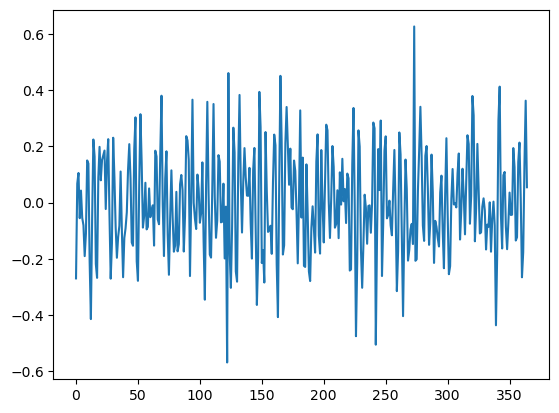

In [17]:
# spectral transform method
temp_fft = fft(sst/std_sst-mean_sst)
flux_fft = fft(flux/std_flux-mean_flux)
kernel_fft = flux_fft/temp_fft
kernel = ifft(kernel_fft)
plt.plot(kernel)

In [18]:
#split data evenly for 11 years
#for training model: X is G_sst(shape: (11,362,1)), Y is H_flux(shape:(11,362,1))
grad_sst = grad_sst[0:m_sample*N_points]
G_sst = np.zeros((m_sample,N_points,1))
for i in range(m_sample):
    G_sst[i,:,0] = np.split(grad_sst,m_sample)[i]
    G_sst[i,:,0] = G_sst[i,:,0]/std_sst-mean_sst

heat_flux = heat_flux[0:m_sample*N_points]
H_flux = np.zeros((m_sample,N_points-kernel_size+1,1))
for i in range(m_sample):
    H_flux[i,:,0] = np.split(heat_flux,m_sample)[i][kernel_size-1:]
    H_flux[i,:,0] = H_flux[i,:,0]/std_flux-mean_flux

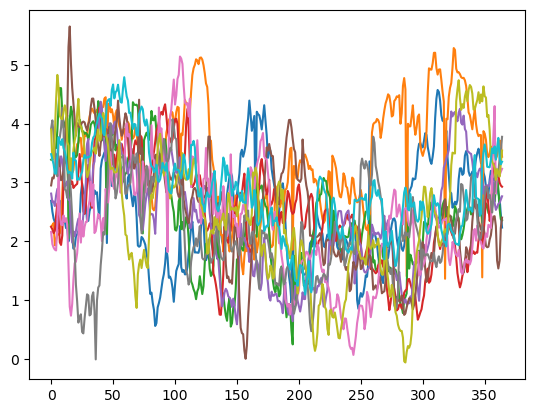

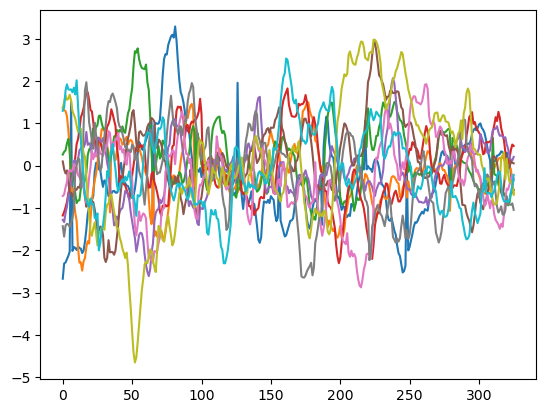

In [19]:
plt.figure()
for i in range(G_sst.shape[0]):
    plt.plot(G_sst[i,:])

plt.figure()
for j in range(H_flux.shape[0]):
    plt.plot(H_flux[j,:])

## plt.plot(G_sst[0,:]-np.mean(G_sst[0,:]),label='temp_grad')
zeros = np.zeros((40,1))
flux_plot = np.concatenate((zeros, H_flux[0,:]-np.mean(H_flux[0,:])),axis = None)
plt.plot(flux_plot,label='heat_flux')
plt.legend()

In [20]:
#run the model
K_kernel = np.zeros((n_kernel,kernel_size))
L_val = np.zeros((n_kernel, n_epoch))
temp_grad = np.zeros((m_sample,N_points,1))
F_flux = np.zeros((m_sample,N_points - kernel_size + 1,1))


for j in range(n_kernel):
    temp_grad = G_sst
    F_flux = H_flux   
    #for i in range(m_sample):
        #temp_grad[i,:,0] = brownian_noise(N_points, leak=0.1, start=0, std=1, source='gaussian')
        #F_flux[i,:,0] = np.convolve(pre_kernel, temp_grad[i,:,0], mode='valid')
    # save kernel
    #K_kernel[j,:] = findkernel(temp_grad,F_flux,time_interval,N_points,tau,m_sample,kernel_size,pre_kernel,tspan,n_epoch)[0]    

(10, 365, 1)

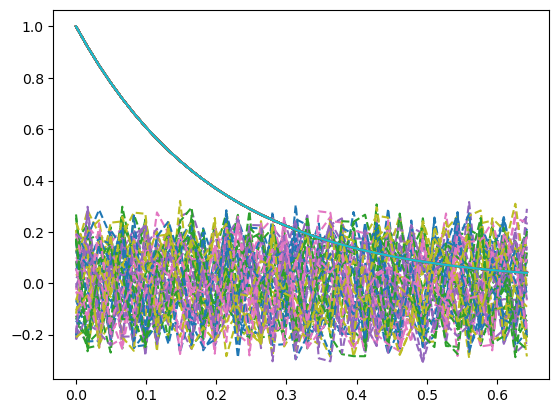

In [7]:
for k in range(n_kernel):
    plt.plot(tspan[:kernel_size], K_kernel[k,:],'--')

    plt.plot(tspan[:kernel_size], pre_kernel[:kernel_size])

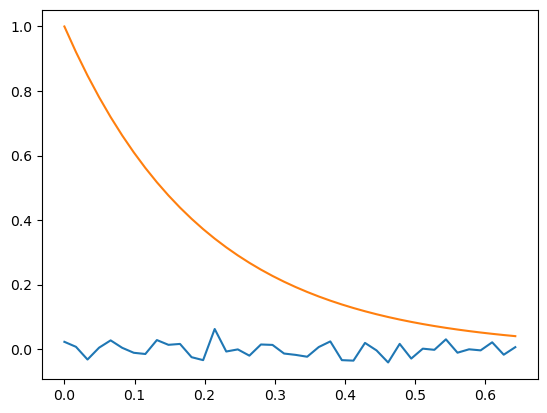

In [8]:
avg_kernel = np.mean(K_kernel[0:n_kernel,:], axis=0)
plt.plot(tspan[:kernel_size], avg_kernel)
plt.plot(tspan[:kernel_size], pre_kernel[:kernel_size])